# Bayes Factor for Gaussian Mixture Model

Consider two data sets. Do they come from the same parent distribution or not?

The classic approach is perform a KS test of the CDFs. The KS test has two big advantages:
1. It is nonparametric.
1. It can be applied to unbinned data of very different sizes.

The problem with the KS test is that provides evidence against the hypothesis that both data sets come from the same parent distribution (the null hypothesis), and thus can be biased against this hypothesis. Moreover, the test is mainly sensitive to differences in the centers of the distributions rather than the tails. Other frequentist tests like the [Anderson-Darling test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35e.htm) attempt to rectify this.

However, if we know that our data are distributed like one or more Gaussians (a Gaussian mixture model) we can bin and fit the data to the model assuming the samples come from the same parent distribution, as well two different parent distributions. We'll call the models $\mathcal{M}_1$ and $\mathcal{M}_2$, respectively. Then the two models can be compared using a likelihood ratio test or a Bayes Factor.

The Bayes Factor is a nice approach because it automatically penalizes more complicated fits. It provides a convenient model comparison in terms of an odds ratio and enables marginalization of nuisance parameters. It also does not require that model $\mathcal{M}_1$ and $\mathcal{M}_2$ be nested, as required when using Wilks' Theorem to convert a likelihood ratio to a $\chi^2$ p-value. The conventional interpretation of the Bayes Factor is discussed in [Kass and Raftery, 1995](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1995.10476572).

This notebook generates two synthetic data sets **from the same parent distribution**, but makes the second data set 60% the size of the first. It then performs a Gaussian mixture fit assuming Poisson uncertainties and demonstrates both maximum likelihood fits and Bayesian analysis using nested sampling. Finally, the Bayes Factor of the two models is computed 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm, ks_2samp
from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import PchipInterpolator
from scipy.special import gammaln
from scipy.optimize import minimize

import numdifftools as ndt

from astropy.io import ascii

import dynesty
from dynesty import plotting as dyplot

mpl.rc('font', size=16)

## Read Data

In [2]:
cols = ['Mstar', 'Mstar_NSA',
        'u_r', 'g_r', 'u_r_NSA' ,'g_r_NSA',
        'rabsmag', 'rabsmag_NSA',
        'SFR', 'sSFR',
        'flag_vsquared',
        'flag_voidfinder']

data = ascii.read('data_flags.dat', include_names=cols)

In [3]:
data

rabsmag,u_r,g_r,Mstar,sSFR,SFR,u_r_NSA,g_r_NSA,rabsmag_NSA,Mstar_NSA,flag_voidfinder,flag_vsquared
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64
-20.101,2.755,0.952,10.55196475982666,-11.68909740447998,-1.0694656372070312,2.5909545388571527,0.8840782662723994,-20.536251068115234,22597765120.0,2,0
-19.256,2.565,0.871,10.169575691223145,-11.156432151794434,-0.9351850748062134,2.2251583317081285,0.7622379303778964,-19.708415985107422,10089863168.0,2,0
-20.959,2.495,0.877,10.911660194396973,-10.782448768615723,0.17625018954277039,2.1127458441288782,0.7120395549037929,-21.317277908325195,45481709568.0,2,0
-21.711,2.88,1.0,11.36347484588623,-11.924013137817383,-0.517741858959198,nan,nan,nan,nan,9,9
-20.604,2.767,0.963,10.833581924438477,-11.989643096923828,-1.1046427488327026,nan,nan,nan,nan,9,9
-21.392,2.576,0.994,11.235125541687012,-11.931730270385742,-0.6697368025779724,nan,nan,nan,nan,9,9
-20.776,2.936,0.925,10.913909912109375,-10.952052116394043,0.012539233081042767,nan,nan,nan,nan,9,9
-20.961,2.775,0.954,11.011194229125977,-11.529818534851074,-0.47579777240753174,nan,nan,nan,nan,9,9
-20.943,2.223,0.749,10.933839797973633,-10.561537742614746,0.41920748353004456,nan,nan,nan,nan,9,9


In [4]:
Mstar = data['Mstar']
Mstar_NSA = data['Mstar_NSA']

# color
u_r = data['u_r']
g_r = data['g_r']
u_r_NSA = data['u_r_NSA']
g_r_NSA = data['g_r_NSA']

# absolute magniture
rabsmag = data['rabsmag']
rabsmag_NSA = data['rabsmag_NSA']

#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
sSFR = np.array(data['sSFR'])

In [5]:
#classification V^2
wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder
wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

In [6]:
def remove_nan(array):
    return array[np.logical_not(np.isnan(array))]

data1 = remove_nan(u_r[wall_vf])
data2 = remove_nan(u_r[void_vf])
bins_ = np.linspace(0,4, 250)

len(data1), len(data2)

(222855, 45521)

Histogram the data (left) and show normalized histograms (right).

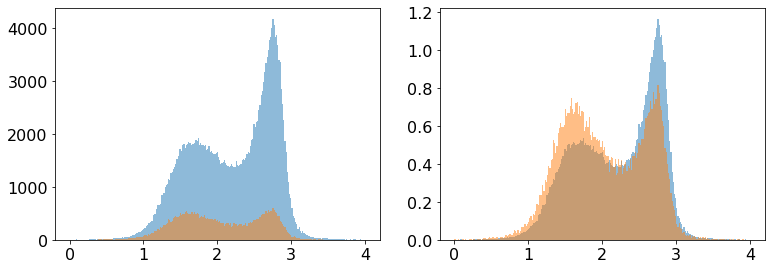

In [7]:
fig, axes = plt.subplots(1,2, figsize=(11,4), sharex=True, tight_layout=True)

ax = axes[0]
ax.hist(data1, bins=bins_, alpha=0.5)
ax.hist(data2, bins=bins_, alpha=0.5)

ax = axes[1]
ax.hist(data1, bins=bins_, alpha=0.5, density=True)
ax.hist(data2, bins=bins_, alpha=0.5, density=True);

### Create Binned Data Sets

Histogram the sets to create two binned data sets used for fitting below.

Text(0, 0.5, 'count')

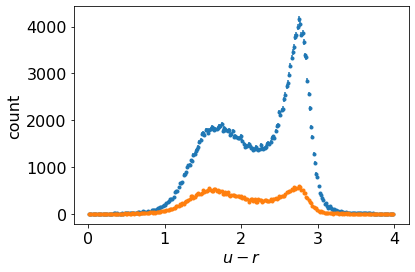

In [8]:
density = False

n1, edges1 = np.histogram(data1, bins=bins_)
dn1 = np.sqrt(n1)
x = 0.5*(edges1[1:] + edges1[:-1])
if density:
    N1 = np.trapz(n1, x1)
    n1, dn1 = n1/N1, dn1/N1
plt.errorbar(x, n1, yerr=dn1, fmt='.')

n2, edges2 = np.histogram(data2, bins=bins_)
dn2 = np.sqrt(n2)
# x = 0.5*(edges2[1:] + edges2[:-1])
if density:
    N2 = np.trapz(n2, x2)
    n2, dn2 = n2/N2, dn2/N2
    
plt.errorbar(x, n2, yerr=dn2, fmt='.')
plt.xlabel('$u-r$')
plt.ylabel('count')

### KS Test

Apply the KS test just to see what the result looks like.

In [9]:
ks, p = ks_2samp(data1, data2)
ks, p

(0.1347316755581539, 0.0)

# Gaussian Mixture Model

## Model $\mathcal{M}_1$: Single Parent Distribution

We have two data sets with binned counts $\mathbf{m}={m_i}$ and $\mathbf{n}={n_i}$. Assume both data sets are created by the same Gaussian mixture model such that the mean count in bin $i$ for data set 1 is

$$
  \lambda_{1,i} = \left[\alpha\mathcal{N}(\mu_\alpha,\sigma_\alpha) + \beta\mathcal{N}(\mu_\beta,\sigma_\beta)\right]_i.
$$

To account for the different sizes in the data sets, we can add a scale factor $s$ to the fit to the second data set:

$$
  \lambda_{2,i} = \left[s\left(\alpha\mathcal{N}(\mu_\alpha,\sigma_\alpha) + \beta\mathcal{N}(\mu_\beta,\sigma_\beta)\right)\right]_i = s\lambda_{1,i}.
$$

Thus the model includes 7 parameters $\theta=\left\{s,\alpha,\mu_\alpha,\sigma_\alpha,\beta,\mu_\beta,\sigma_\beta\right\}$.

### Maximum Likelihood Result

We want to maximize the joint Poisson likelihood

$$
  p(\mathbf{m},\mathbf{n}|\lambda_1,\lambda_2,\mathcal{M}_1)
  = \prod_{i=1}^N \frac{\lambda_{1,i}^{m_i}e^{-\lambda_{1,i}}}{m_i!}
  \frac{\lambda_{2,i}^{n_i}e^{-\lambda_{2,i}}}{n_i!},
$$

or minimize the negative log likelihood

$$
-\ln{\mathcal{L}} = -\sum_{i=1}^N \left(m_i\lambda_{1,i}-\lambda_{1,i}-\ln{m_i!} + 
n_i\lambda_{2,i}-\lambda_{2,i}-\ln{n_i!}\right).
$$

In [12]:
def mixturemodel_norm(params, x):
    """Mixture of two skew normal distributions.
    
    Parameters
    ----------
    params : list or ndarray
        List of parameters (expect 2x3).
    x : float or ndarray
        Values to calculate the model.
    
    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """
    a, mu_a, sigma_a = params[:3]
    b, mu_b, sigma_b = params[3:]
    return a*norm.pdf(x, loc=mu_a, scale=sigma_a) + b*norm.pdf(x, loc=mu_b, scale=sigma_b)

def logLjoint1_norm(params, m, n, x):
    """Joint log-likelihood of the two data sets.
    
    Parameters
    ----------
    params : list or ndarray
        List of 7 parameters: 2x3 Gaussian pars + scale factor.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
        
    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """
    s, pars = params[0], params[1:]
    
    lambda1 = mixturemodel_norm(pars, x)
    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    
    lambda2 = s*lambda1
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))

def nlogLjoint1_norm(params, m, n, x):
    """Negative log-likelihood, for minimizers."""
    return -logLjoint1_norm(params, m, n, x)

#### Maxmize the Likelihood

Find the maximum likelihood parameters of model $\mathcal{M}_1$ by minimizing $-\ln{\mathcal{L}}$.

Perform a bounded fit using the L-BFGS-B algorithm.

In [13]:
# Parameter bounds.
bounds1 = [[0.1, 10.],     # s ........ scale factor (peak 1 to 2)
           [100., 5000.],  # a ........ Gaussian 1 amplitude
           [0.0, 2.0],     # mu_a ..... Gaussian 1 location
           [0.1, 3.0],     # sigma_a .. Gaussian 1 scale
           [100., 5000.],  # b ........ Gaussian 2 amplitude
           [2.0, 4.0],     # mu_b ..... Gaussian 2 location
           [0.1, 3.0]]     # sigma_b .. Gaussian 2 scale

# Generate 10 random seeds for the minimizer.
# Store the result with the lowest -ln(L) in bestfit.
bestfit = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1]
    result = minimize(nlogLjoint1_norm, p0, method='L-BFGS-B', args=(n1, n2, x), bounds=bounds1)
    
    if result.success:
        print(p0)
        print('  {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result

bestfit

[5.75277351742047, 1419.4313212839122, 1.401799370772105, 0.2681924010951726, 4231.649570775733, 2.9614537916949155, 2.3830466995991726]
  43323.80
[1.2173624802675258, 4837.0196461174055, 0.5229479881966201, 1.7627204405933123, 1959.2982235998563, 2.9965830209760824, 0.8901796771730603]
  43323.80
[1.5302648490429873, 3126.3763008708083, 1.5002595452674998, 0.8050563589709587, 2126.4934750480506, 3.83075949287592, 1.6903304312114213]
  72246.34
[2.5649302970552816, 369.82453531687804, 1.3606644800416543, 0.4541191761166, 1392.84068313111, 3.2185935242621593, 0.4413543092088811]
  7023.32
[3.9863704013377603, 254.9264494455403, 0.8278354569174609, 2.5112436240236926, 4408.917438239521, 3.8869790251591914, 0.391219526776026]
  87371.83
[6.297370122548639, 3530.007874946905, 0.767774953111384, 1.6984434789692515, 3993.7547753971526, 3.047641812042543, 2.8548275743734646]
  43323.80
[8.19306347063951, 4162.212701695462, 1.9192797541618725, 1.6965452567246757, 272.72682541025677, 3.0087881

      fun: 7023.319907781948
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.32123353,  0.00236469, -0.38726284, -0.16761987,  0.00291038,
       -0.21245796, -0.79780875])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 608
      nit: 40
   status: 0
  success: True
        x: array([2.04199338e-01, 2.33137660e+03, 1.89110709e+00, 4.76071794e-01,
       1.24369984e+03, 2.73198269e+00, 1.48684986e-01])

#### Plot Maximum Likelihood Fit

Plot the best fit results on top of the binned data.

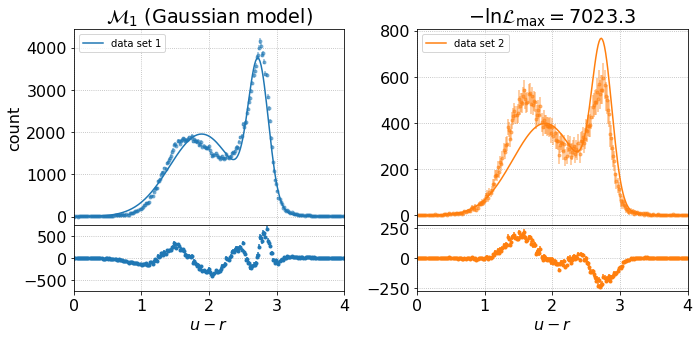

In [14]:
fig, axes = plt.subplots(2,2, figsize=(10,5), sharex=True,
                         gridspec_kw={'height_ratios':[3,1], 'hspace':0},
                         tight_layout=True)

ax = axes[0,0]
ep = ax.errorbar(x, n1, yerr=dn1, fmt='.', alpha=0.5)
ax.plot(x, mixturemodel_norm(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 1')
ax.set(ylabel='count',
       title=r'$\mathcal{M}_1$ (Gaussian model)')
ax.grid(ls=':')
ax.legend(fontsize=10)

ax = axes[1,0]
ax.errorbar(x, n1 - mixturemodel_norm(bestfit.x[1:], x), yerr=dn1, fmt='.')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-750,750))

ax = axes[0,1]
ep = ax.errorbar(x, n2, yerr=dn1, fmt='.', color='#ff7f0e', alpha=0.5)
ax.plot(x, bestfit.x[0]*mixturemodel_norm(bestfit.x[1:], x), color=ep[0].get_color(), label='data set 2')
ax.grid(ls=':')
ax.set(title=r'$-\ln{{\mathcal{{L}}_\mathrm{{max}}}}={{{:.1f}}}$'.format(bestfit.fun))
ax.legend(fontsize=10)

ax = axes[1,1]
ax.errorbar(x, n2 - bestfit.x[0]*mixturemodel_norm(bestfit.x[1:], x), yerr=dn2, fmt='.', color='#ff7f0e')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-275,275))

fig.savefig('ml_model1_ur_norm.png', dpi=100)

### Nested Sampling of the Likelihood and Priors

Use the `dynesty` nested sampler to generate samples from the posterior PDF

$$
p(\vec{\theta},\mathcal{M}_1|\mathbf{m},\mathbf{n}) \propto p(\mathbf{m},\mathbf{n}|\vec{\theta},\mathcal{M}_1)\ 
p(\vec{\theta}|\mathcal{M}_1)
$$

where $\vec{\theta}=(s,\alpha,\mu_\alpha,\sigma_\alpha,\beta,\mu_\beta,\sigma_\beta)$ is the list of parameters in the model. We can assume the prior probability of the parameters

$$
p(\vec{\theta}|\mathcal{M}_1)
$$

is the product of 7 independent distributions for the 7 parameters. See below for implementation.

In [15]:
def uniform(a, b, u):
    """Given u in [0,1], return a uniform number in [a,b]."""
    return a + (b-a)*u

def jeffreys(a, b, u):
    """Given u in [0,1], return a Jeffreys random number in [a,b]."""
    return a**(1-u) * b**u

def prior_xform1(u):
    """Priors for the 7 parameters of model M1. Required by the dynesty sampler.
    
    Parameters
    ----------
    u : ndarray
        Array of uniform random numbers between 0 and 1.
        
    Returns
    -------
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    """
    s       = uniform(0.2, 10., u[0])
    a       = jeffreys(1., 1e4, u[1])
    mu_a    = uniform(0., 2., u[2])
    sigma_a = jeffreys(0.1, 2., u[3])
    b       = jeffreys(1., 1e4, u[4])
    mu_b    = uniform(2., 4., u[5])
    sigma_b = jeffreys(0.1, 2., u[6])
    
    return s, a, mu_a, sigma_a, b, mu_b, sigma_b

#### Run the Nested Sampler

In [16]:
dsampler = dynesty.DynamicNestedSampler(logLjoint1_norm, prior_xform1, ndim=7,
                                        logl_args=(n1, n2, x),
                                        nlive=1000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres1 = dsampler.results

38529it [06:41, 96.04it/s, batch: 7 | bound: 173 | nc: 1 | ncall: 146635 | eff(%): 26.275 | loglstar: -7031.589 < -7023.516 < -7024.953 | logz: -7070.607 +/-  0.411 | stop:  0.947]          


#### Produce a Corner Plot of the Best Fit Parameters

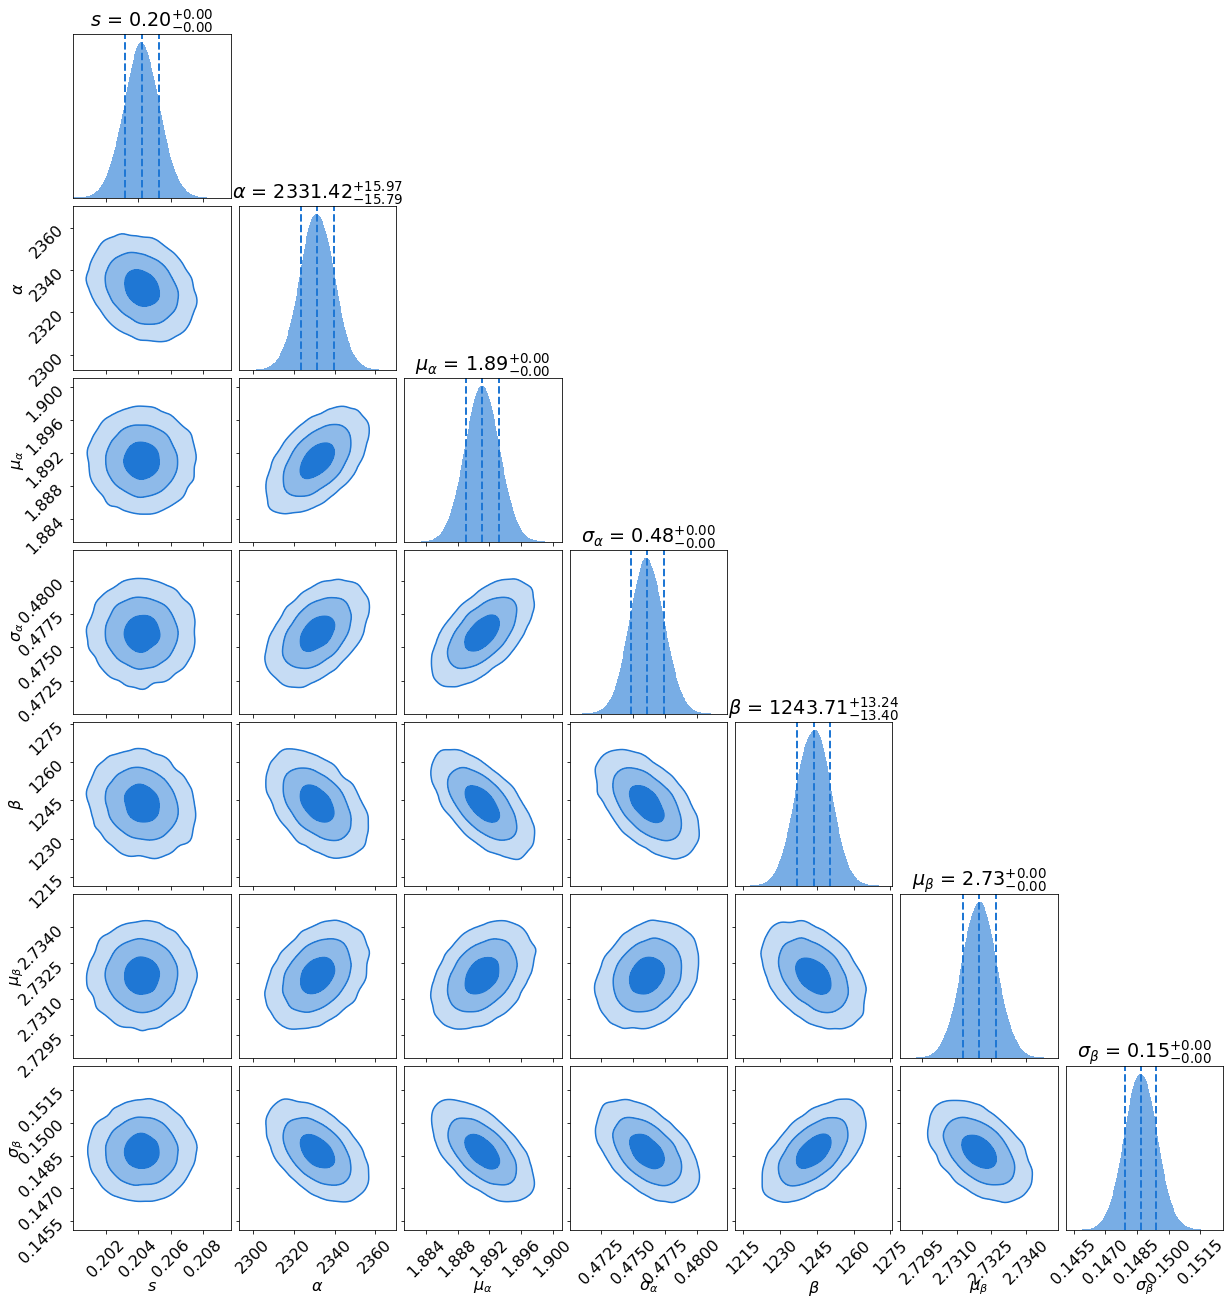

In [17]:
labels = ['$s$', r'$\alpha$', r'$\mu_\alpha$', r'$\sigma_\alpha$',
                 r'$\beta$',  r'$\mu_\beta$',  r'$\sigma_\beta$']

fig, axes = dyplot.cornerplot(dres1, smooth=0.03,
                              labels=labels,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(7, 7, figsize=(2.5*7,2.6*7)),
                              color='#1f77d4')

fig.savefig('corner_model1_ur_norm.png', dpi=100)

### MAP Value Plot

Take the maximum a posteriori (MAP) values of the parameters and plot the best fit results.

In [18]:
mapvals1 = np.zeros(7, dtype=float)
for i in range(7):
    x16, x50, x84 = dynesty.utils.quantile(dres1.samples[:,i],
                                           np.asarray([0.16, 0.5, 0.84]))
    mapvals1[i] = x50

mapvals1

array([2.05334078e-01, 2.32705276e+03, 1.89018035e+00, 4.76075909e-01,
       1.24422363e+03, 2.73178285e+00, 1.49090408e-01])

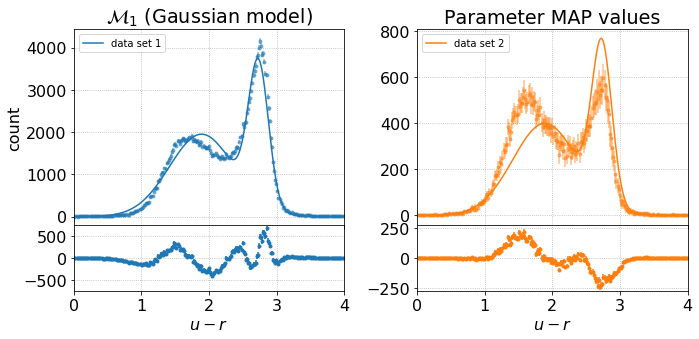

In [20]:
fig, axes = plt.subplots(2,2, figsize=(10,5), sharex=True,
                         gridspec_kw={'height_ratios':[3,1], 'hspace':0},
                         tight_layout=True)

ax = axes[0,0]
ep = ax.errorbar(x, n1, yerr=dn1, fmt='.', alpha=0.5)
ax.plot(x, mixturemodel_norm(mapvals1[1:], x), color=ep[0].get_color(), label='data set 1')
ax.set(ylabel='count',
       title=r'$\mathcal{M}_1$ (Gaussian model)')
ax.grid(ls=':')
ax.legend(fontsize=10)

ax = axes[1,0]
ax.errorbar(x, n1 - mixturemodel_norm(mapvals1[1:], x), yerr=dn1, fmt='.')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-750,750))

ax = axes[0,1]
ep = ax.errorbar(x, n2, yerr=dn1, fmt='.', color='#ff7f0e', alpha=0.5);
ax.plot(x, mapvals1[0]*mixturemodel_norm(mapvals1[1:], x), color=ep[0].get_color(), label='data set 2')
ax.grid(ls=':')
ax.set(title='Parameter MAP values')
ax.legend(fontsize=10)

ax = axes[1,1]
ax.errorbar(x, n2 - mapvals1[0]*mixturemodel_norm(mapvals1[1:], x), yerr=dn2, fmt='.', color='#ff7f0e')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-275,275))

fig.savefig('map_model1_ur_norm.png')

### Store the Bayesian Evidence

The nested sampler computes the logarithm of the Bayesian evidence $\ln{Z}$, where

$$
Z = p(\mathbf{m},\mathbf{n}|\mathcal{M}_1)
  = \int\mathrm{d}\vec{\theta}\ p(\mathbf{m},\mathbf{n}|\vec{\theta}, \mathcal{M}_1).
$$

That is, we obtain the evidence for the model $\mathcal{M}_1$ marginalizing over all parameter values $\vec{\theta}$ allowed by the prior. This term will be used later in the Bayes Factor.

In [21]:
lnzM1 = dres1.logz[-1]
lnzM1

-7070.591086189055

## Model $\mathcal{M}_2$: Two Parent Distribution

In this case assumed the data with binned counts $\mathbf{m}={m_i}$ and $\mathbf{n}={n_i}$ are created by separate Gaussian mixture models with mean count

$$
  \lambda_{1,i} = \left[\alpha\mathcal{N}(\mu_\alpha,\sigma_\alpha) + \beta\mathcal{N}(\mu_\beta,\sigma_\beta)\right]_i
$$

in set 1 and mean count

$$
  \lambda_{2,i} = \left[\left(\gamma\mathcal{N}(\mu_\gamma,\sigma_\gamma) + \delta\mathcal{N}(\mu_\delta,\sigma_\delta)\right)\right]_i
$$

in set 2.

Thus the model includes 12 free parameters $\theta=\left\{\alpha,\mu_\alpha,\sigma_\alpha,\beta,\mu_\beta,\sigma_\beta,\gamma,\mu_\gamma,\sigma_\gamma,\delta,\mu_\delta,\sigma_\delta\right\}$.

### Maximum Likelihood Result

As before, maximize the joint Poisson likelihood

$$
  p(\mathbf{m},\mathbf{n}|\lambda_1,\lambda_2,\mathcal{M}_2)
  = \prod_{i=1}^N \frac{\lambda_{1,i}^{m_i}e^{-\lambda_{1,i}}}{m_i!}
  \frac{\lambda_{2,i}^{n_i}e^{-\lambda_{2,i}}}{n_i!},
$$

or minimize the negative log likelihood

$$
-\ln{\mathcal{L}} = -\sum_{i=1}^N \left(m_i\lambda_{1,i}-\lambda_{1,i}-\ln{m_i!} + 
n_i\lambda_{2,i}-\lambda_{2,i}-\ln{n_i!}\right).
$$

In [22]:
def logLjoint2_norm(params, m, n, x):
    """Joint log-likelihood of the two data sets.
    
    Parameters
    ----------
    params : list or ndarray
        List of 12 parameters: 2x3x2 Gaussian components.
    m : ndarray
        Binned counts in data set 1.
    n : ndarray
        Binned counts in data set 2.
    x : ndarray
        Bin centers used to construct the histogrammed counts m and n.
        
    Returns
    -------
    logL : float
        Log likelihood of sets m and n given model parameters.
    """
    lambda1 = mixturemodel_norm(params[:6], x)
    lambda1[lambda1<=0] = np.finfo(dtype=np.float64).tiny
    
    lambda2 = mixturemodel_norm(params[6:], x)
    lambda2[lambda2<=0] = np.finfo(dtype=np.float64).tiny
    
    return np.sum(m*np.log(lambda1) - lambda1 - gammaln(m+1) + n*np.log(lambda2) - lambda2 - gammaln(n+1))

def nlogLjoint2_norm(params, m, n, x):
    """Negative log likelihood, for minimizers."""
    return -logLjoint2_norm(params, m, n, x)

#### Minimize the Log Likelihood

Minimize the log likelihood, using several different seeds.

In [23]:
bounds1_ = [[100., 5000.],  # a ........ Gaussian 1 amplitude
            [0.0, 2.0],     # mu_a ..... Gaussian 1 location
            [0.1, 3.0],     # sigma_a .. Gaussian 1 scale
            [100., 5000.],  # b ........ Gaussian 2 amplitude
            [2.0, 4.0],     # mu_b ..... Gaussian 2 location
            [0.1, 3.0]]     # sigma_b .. Gaussian 2 scale

bounds2_ = [[100., 600.],    # a ........ Gaussian 1 amplitude
            [0.0, 2.0],     # mu_a ..... Gaussian 1 location
            [0.1, 2.0],     # sigma_a .. Gaussian 1 scale
            [100., 600.],    # b ........ Gaussian 2 amplitude
            [2.0, 4.0],     # mu_b ..... Gaussian 2 location
            [0.1, 2.0]]     # sigma_b .. Gaussian 2 scale

bounds2 = bounds1_ + bounds2_

bestfit = None

for i in range(20):
    p0 = [np.random.uniform(b[0], b[1]) for b in bounds2]
    result = minimize(nlogLjoint2_norm, p0, method='L-BFGS-B', args=(n1, n2, x), bounds=bounds2)
    
    if result.success:
        print(p0)
        print('  {:.2f}'.format(result.fun))
        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result

bestfit

[1533.5666263371913, 0.29707947119458633, 2.389274173396674, 410.35637107044437, 3.038328402113577, 2.8266357565269327, 200.67178456881348, 0.4739089445943383, 1.2475155414312697, 330.44563843047416, 2.6428375486987856, 0.9021023431688229]
  7836.32
[4913.554082515747, 0.47713389354530733, 1.5095057568508883, 3780.9654089334485, 3.0373273349243957, 0.9508071556313259, 128.67308559079373, 1.5391676329545103, 1.3406957399805133, 543.3405686933331, 3.6464388365098404, 1.3758788587416015]
  37470.13
[1726.0210516375419, 0.9959755550136968, 2.947180663383028, 4418.534706574771, 2.1405351613272696, 2.0246328521582044, 366.06716345091496, 1.0974752434225903, 0.9957570135137339, 381.99581262038976, 3.5917519539820666, 0.5255449701029328]
  37470.13
[4904.656073468226, 0.11483459184990408, 0.8546578352227784, 2815.116832406515, 2.911676830765276, 1.6409687493095082, 188.9202658321983, 0.2790671709934469, 1.4622254512443216, 439.57431279412384, 3.5573366346059117, 1.0300943536438703]
  37470.13


      fun: 5203.323360540241
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09494702e-05, -2.78023435e+00,  2.97959559e+00, -1.63709046e-03,
        2.26327757e+00, -1.84072633e+00, -1.54614099e-03,  2.77395884e-02,
       -1.24173312e+00, -3.00133252e-03, -1.35960363e+00, -1.92130756e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5005
      nit: 330
   status: 0
  success: True
        x: array([2.27093560e+03, 1.91284497e+00, 4.77960110e-01, 1.30402507e+03,
       2.73525606e+00, 1.47191305e-01, 5.35214980e+02, 1.79815591e+00,
       4.57014412e-01, 1.94793219e+02, 2.70691381e+00, 1.58504307e-01])

#### Plot the Best Fit

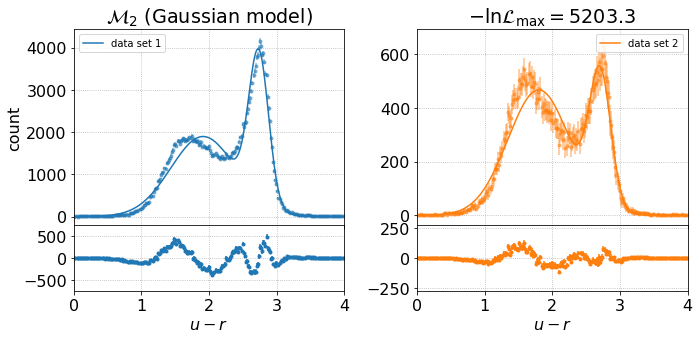

In [24]:
fig, axes = plt.subplots(2,2, figsize=(10,5), sharex=True,
                         gridspec_kw={'height_ratios':[3,1], 'hspace':0},
                         tight_layout=True)

ax = axes[0,0]
ep = ax.errorbar(x, n1, yerr=dn1, fmt='.', alpha=0.5)
ax.plot(x, mixturemodel_norm(bestfit.x[:6], x), color=ep[0].get_color(), label='data set 1')
ax.set(ylabel='count',
       title=r'$\mathcal{M}_2$ (Gaussian model)')
ax.grid(ls=':')
ax.legend(fontsize=10)

ax = axes[1,0]
ax.errorbar(x, n1 - mixturemodel_norm(bestfit.x[:6], x), yerr=dn1, fmt='.')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-750,750))

ax = axes[0,1]
ep = ax.errorbar(x, n2, yerr=dn1, fmt='.', color='#ff7f0e', alpha=0.5)
ax.plot(x, mixturemodel_norm(bestfit.x[6:], x), color=ep[0].get_color(), label='data set 2')
ax.grid(ls=':')
ax.set(title=r'$-\ln{{\mathcal{{L}}_\mathrm{{max}}}}={{{:.1f}}}$'.format(bestfit.fun))
ax.legend(fontsize=10)

ax = axes[1,1]
ax.errorbar(x, n2 - mixturemodel_norm(bestfit.x[6:], x), yerr=dn2, fmt='.', color='#ff7f0e')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-275,275))

fig.savefig('ml_model2_ur_norm.png', dpi=100)

### Nested Sampling of the $\mathcal{M}_2$ Likelihood and Priors

In [25]:
def prior_xform2(u):
    a       = jeffreys(1., 1e4, u[0])
    mu_a    = uniform(0., 2., u[1])
    sigma_a = jeffreys(0.1, 2., u[2])
    b       = jeffreys(1., 1e4, u[3])
    mu_b    = uniform(2., 4., u[4])
    sigma_b = jeffreys(0.1, 2., u[5])
    
    c       = jeffreys(1., 1e4, u[6])
    mu_c    = uniform(0., 2., u[7])
    sigma_c = jeffreys(0.1, 2., u[8])
    d       = jeffreys(1., 1e4, u[9])
    mu_d    = uniform(2., 4., u[10])
    sigma_d = jeffreys(0.1, 2., u[11])
    
    return a, mu_a, sigma_a, b, mu_b, sigma_b, c, mu_c, sigma_c, d, mu_d, sigma_d

In [26]:
dsampler = dynesty.DynamicNestedSampler(logLjoint2_norm, prior_xform2, ndim=12,
                                        logl_args=(n1, n2, x),
                                        nlive=3000,
                                        bound='multi',
                                        sample='auto')

dsampler.run_nested()
dres2 = dsampler.results

8170it [02:25, 51.98it/s, batch: 0 | bound: 99 | nc: 25 | ncall: 180223 | eff(%):  4.521 | loglstar:   -inf < -25509.661 <    inf | logz: -25532.892 +/-  0.305 | dlogz: 11012.527 >  0.010]  /Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8512it [02:32, 54.15it/s, batch: 0 | bound: 104 | nc: 25 | ncall: 188995 | eff(%):  4.492 | loglstar:   -inf < -23109.097 <    inf | logz: -23132.228 +/-  0.302 | dlogz: 10106.170 >  0.010]/Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8677it [02:36, 54.49it/s, batch: 0 | bound: 107 | nc: 25 | ncall: 194226 | eff(%):  4.456 | loglstar:   -inf < -22050.785 <

/Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
10677it [03:40, 52.96it/s, batch: 0 | bound: 154 | nc: 25 | ncall: 271959 | eff(%):  3.919 | loglstar:   -inf < -14241.688 <    inf | logz: -14269.341 +/-  0.329 | dlogz: 6373.394 >  0.010]/Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/sybenzvi/.local/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
10861it [03:45, 52.23it/s, batch: 0 | bound: 158 | nc: 25 | ncall: 278669 | eff(

#### Corner Plot of the Nested Sampling Results

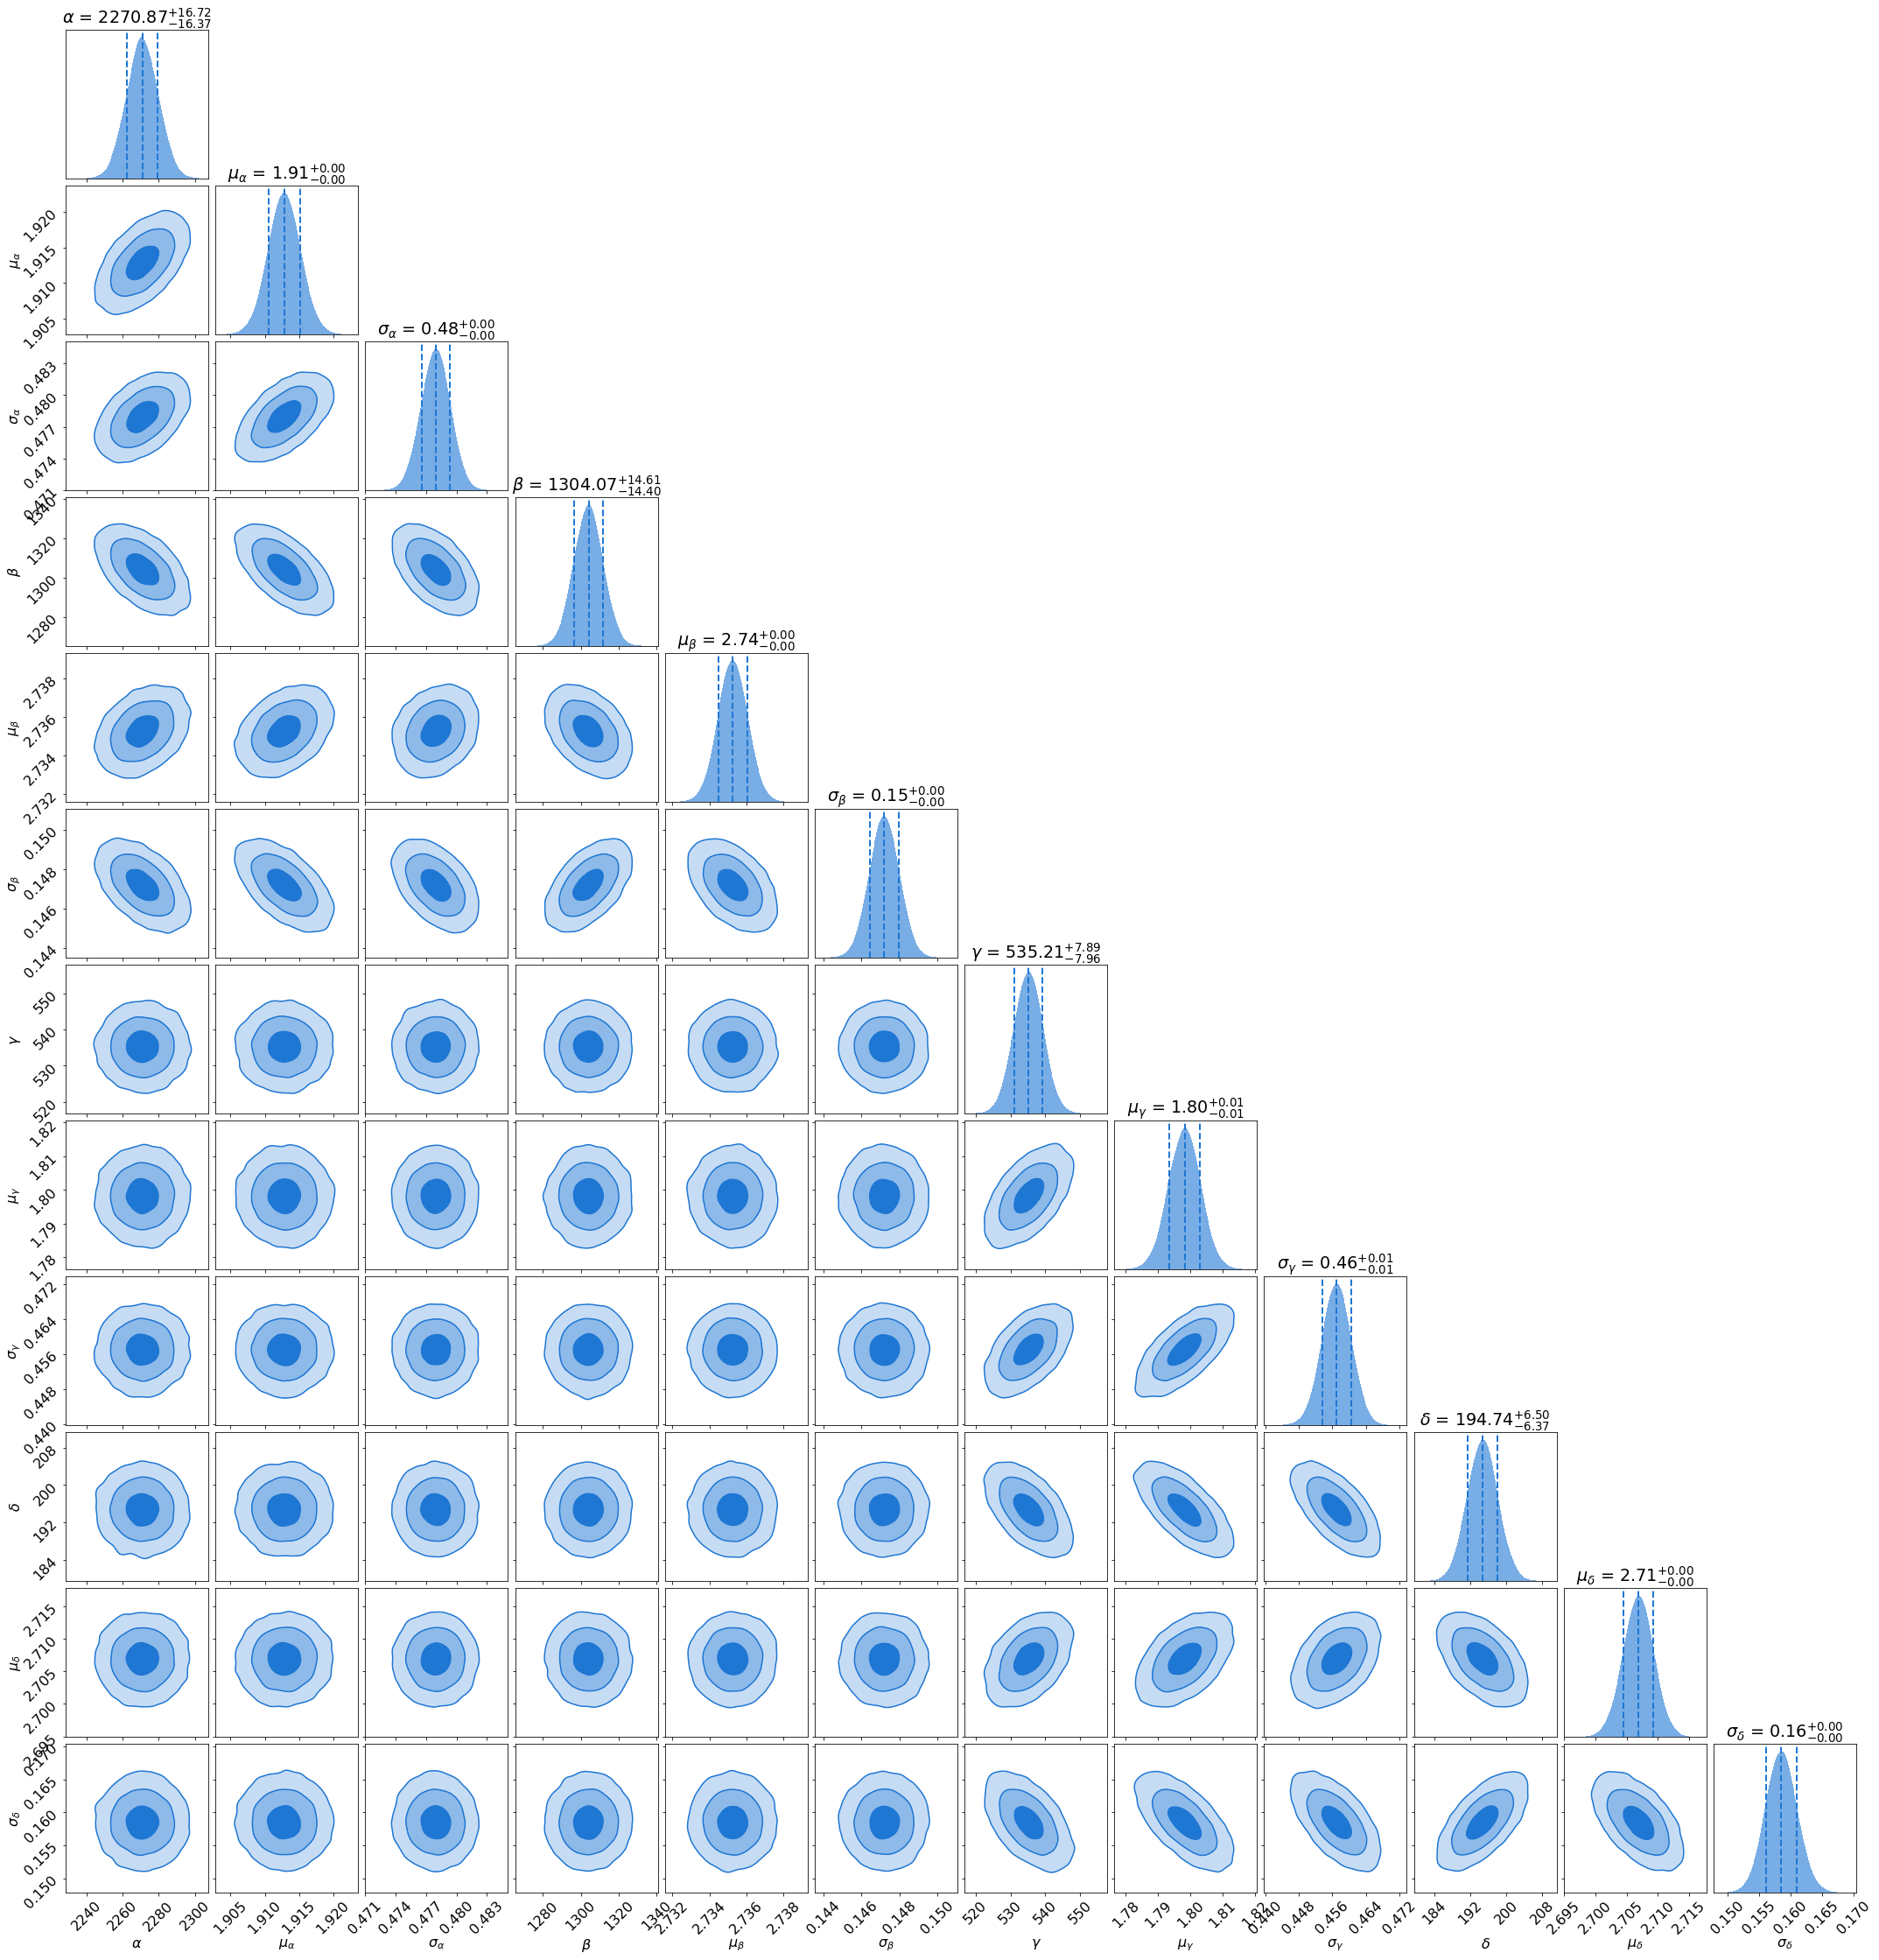

In [27]:
labels = [r'$\alpha$', r'$\mu_{\alpha}$', r'$\sigma_{\alpha}$',
          r'$\beta$',  r'$\mu_{\beta}$',  r'$\sigma_{\beta}$',
          r'$\gamma$', r'$\mu_{\gamma}$', r'$\sigma_{\gamma}$',
          r'$\delta$', r'$\mu_{\delta}$', r'$\sigma_{\delta}$']

fig, axes = dyplot.cornerplot(dres2, smooth=0.03,
#                               title_kwargs={'y': 1.03},
                              labels=labels,
#                               truths=xmax,
                              show_titles=True,
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1.,2.,3]],
                              quantiles=[0.16, 0.5, 0.84],
                              fig=plt.subplots(12, 12, figsize=(2.5*12,2.6*12)),
                              color='#1f77d4')

fig.savefig('corner_model2_ur_norm.png', dpi=100)

### MAP Value Plot

Take the maximum a posteriori (MAP) values of the parameters and plot the best fit results.

In [29]:
mapvals2 = np.zeros(12, dtype=float)
for i in range(12):
    x16, x50, x84 = dynesty.utils.quantile(dres2.samples[:,i],
                                           np.asarray([0.16, 0.5, 0.84]))
    mapvals2[i] = x50

mapvals2

array([2.26749420e+03, 1.91164323e+00, 4.77815129e-01, 1.30620824e+03,
       2.73498640e+00, 1.47675466e-01, 5.33461800e+02, 1.79583440e+00,
       4.57341900e-01, 1.95596648e+02, 2.70601735e+00, 1.60702116e-01])

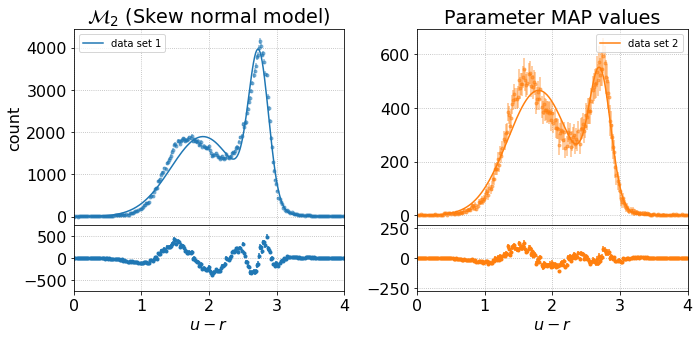

In [34]:
fig, axes = plt.subplots(2,2, figsize=(10,5), sharex=True,
                         gridspec_kw={'height_ratios':[3,1], 'hspace':0},
                         tight_layout=True)

ax = axes[0,0]
ep = ax.errorbar(x, n1, yerr=dn1, fmt='.', alpha=0.5)
ax.plot(x, mixturemodel_norm(mapvals2[:6], x), color=ep[0].get_color(), label='data set 1')
ax.set(ylabel='count',
       title=r'$\mathcal{M}_2$ (Skew normal model)')
ax.grid(ls=':')
ax.legend(fontsize=10)

ax = axes[1,0]
ax.errorbar(x, n1 - mixturemodel_norm(mapvals2[:6], x), yerr=dn1, fmt='.')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-750,750))

ax = axes[0,1]
ep = ax.errorbar(x, n2, yerr=dn1, fmt='.', color='#ff7f0e', alpha=0.5);
ax.plot(x, mixturemodel_norm(mapvals2[6:], x), color=ep[0].get_color(), label='data set 2')
ax.grid(ls=':')
ax.set(title='Parameter MAP values')
ax.legend(fontsize=10)

ax = axes[1,1]
ax.errorbar(x, n2 - mixturemodel_norm(mapvals2[6:], x), yerr=dn2, fmt='.', color='#ff7f0e')
ax.grid(ls=':')

ax.set(xlim=(0, 4),
       xlabel='$u-r$',
       ylim=(-275,275))

fig.savefig('map_model2_ur_norm.png', dpi=100)

### Bayesian Evidence

Store the Bayesian evidence

$$
\ln{Z}_2 = \ln{p(\mathbf{m},\mathbf{n}|\mathcal{M}_2)}
$$

for later use in the Bayes Factor.

In [31]:
lnzM2 = dres2.logz[-1]
lnzM2

-5273.955535933883

## Bayes Factor

The Bayes Factor giving the odds ratio of the two models is

$$
\ln{B_{12}} = \ln{\left(\frac{p(\mathbf{m},\mathbf{n}|\mathcal{M}_1)}{p(\mathbf{m},\mathbf{n}|\mathcal{M}_2)}\right)}
= \ln{Z_1} - \ln{Z_2}
$$

In [32]:
lnB12 = lnzM1 - lnzM2
logB12 = 0.43429 * lnB12
logB12

-780.2608531203189

In [33]:
B12 = 10**logB12
print('B12 = {:g}; log(B12) = {:.1f}'.format(B12, logB12))

B12 = 0; log(B12) = -780.3


Thus model $\mathcal{M}_1$ (in which the two data sets come from the same distribution) is totally disfavored.